In [274]:
import numpy as np
import pandas as pd
from dtaidistance import dtw
from matplotlib import pyplot as plt

**Import Files**

In [275]:
model_output_csv_path = "../../../data/model_output/start_2023-11-21T17-37-01.696+00-00.csv"

model_detections = pd.read_csv(model_output_csv_path, delimiter=",")

ground_truth_csv = "../../../data/labels/start_2023-11-21T17-37-01.696+00-00_ground_truth.csv"

ground_truth = pd.read_csv(ground_truth_csv, delimiter=",")

value_counts_model = pd.DataFrame(model_detections.id.value_counts()).reset_index().rename(columns={"index": "id", "id": "occurences"})

value_counts_truth =  pd.DataFrame(ground_truth.id.value_counts()).reset_index().rename(columns={"index": "id", "id": "occurences"})

In [276]:
model_detections.to_csv("wat.csv", index=False)
value_counts_model = value_counts_model[value_counts_model.occurences >= 60]
model_detections = model_detections[model_detections['id'].isin(value_counts_model['id'])]


In [277]:
import numpy as np

def calculate_metrics(group):
    # Calculate the Euclidean distance between previous and current positions
    x_diff = np.diff(group['x'])
    y_diff = np.diff(group['y'])
    euclidean_distances = np.sqrt(x_diff**2 + y_diff**2)
    
    # Calculate the sum of distances over the group
    traversed_distance = np.sum(euclidean_distances)
    
    # Calculate the frame number difference
    frame_diff = group['frame'].iloc[-1] - group['frame'].iloc[0]
    
    return pd.Series({'traversed_distance': traversed_distance, 'frame_diff': frame_diff})

# Apply the function to each group and join the results with the original dataframe
feature_df = model_detections.groupby('id').apply(calculate_metrics)


In [281]:
from sklearn.cluster import KMeans

def cluster_features(feature_df, features, clustering_method, n_clusters):
    # Select the specified features from the feature_df
    selected_features = feature_df[features]
    
    # Perform clustering using the specified method and number of clusters
    clustering = clustering_method(n_clusters=n_clusters)
    labels = clustering.fit_predict(selected_features)
    
    # Add the cluster labels to the feature_df
    feature_df['cluster'] = labels
    
    return feature_df

features = ['traversed_distance', 'frame_diff']
clustering_method = KMeans
n_clusters = 3

clustered_features = cluster_features(feature_df, features, clustering_method, n_clusters)
model_detections = pd.merge(model_detections, clustered_features.reset_index()[['id', 'cluster']], on='id')

clustered_features

,traversed_distance,frame_diff,cluster
id,,,
40,22.721612,99.0,0
135,132.515122,146.0,2
281,53.093832,332.0,1
405,152.735825,158.0,2
682,202.108265,271.0,1
...,...,...,...
11349,209.776292,312.0,1
11378,20.614627,95.0,0
11634,167.182242,106.0,2


**PLOT PATHS**

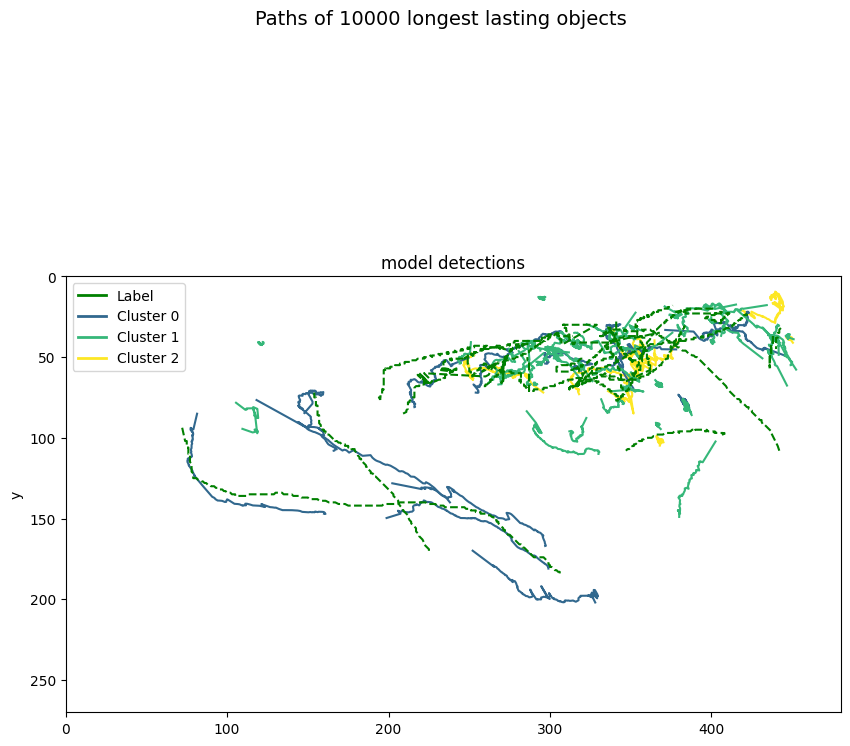

In [53]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

amount = 10000
alpha = 1
label_color = "green"

# Create a colormap with enough colors for each cluster
n_clusters = clustered_features['cluster'].nunique()
colormap = cm.get_cmap('viridis', n_clusters + 1)  # +1 for the ground truth color

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True,  figsize=(10, 10))
plt.gca().invert_yaxis()

# Plot model detections
for object in value_counts_model.id.tolist()[:amount]:
    cluster = model_detections.loc[model_detections.id == object, "cluster"].iloc[0]
    if pd.isna(cluster):
        color = colormap(0)  # Use the first color for unclustered objects
    else:
        color = colormap(cluster + 1)  # +1 to skip the first color
    ax.plot(model_detections.loc[model_detections.id == object, "x"], model_detections.loc[model_detections.id == object, "y"], alpha=alpha, color=color)

# Plot ground truth
for object in value_counts_truth.id.tolist():
    ax.plot(ground_truth.loc[ground_truth.id == object, "x"], ground_truth.loc[ground_truth.id == object, "y"], alpha=alpha, color=label_color, linestyle='dashed')

ax.set(ylabel='y',
       title="model detections", ylim=[270, 0], xlim=[0, 480])
ax.set_aspect('equal', adjustable='box')
fig.suptitle(f"Paths of {amount} longest lasting objects", fontsize=14)

# Create a custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=label_color, lw=2, label='Label')]
for i in range(n_clusters):
    legend_elements.append(Line2D([0], [0], color=colormap(i + 1), lw=2, label=f'Cluster {i}'))
ax.legend(handles=legend_elements)

plt.show()

In [284]:
from tqdm import tqdm
import numpy as np
import motmetrics
from motmetrics.distances import iou_matrix, boxiou
from scipy.optimize import linear_sum_assignment

min_iou_thresh = 0.4
min_overlap_ratio = 0.3

# Create an accumulator to store the tracking metrics
acc = motmetrics.MOTAccumulator(auto_id=True)

# Store the closest trajectories
closest_trajectories = {}

track_distances = np.empty((len(model_detections['id'].unique()), len(ground_truth['id'].unique())))
# Iterate over each track in model_detections
for mmt_idx, track_id in tqdm(enumerate(model_detections['id'].unique())):
    # Convert the track data to MOT format
    mmt_track = model_detections.loc[model_detections['id'] == track_id, ['frame', 'x', 'y', 'w', 'h']]
    
    closest_gt_id = None

    # Get the corresponding ground truth track
    for gt_idx, gt_id in enumerate(ground_truth['id'].unique()):
        gt_track = ground_truth.loc[ground_truth['id'] == gt_id, ['frame', 'x', 'y', 'w', 'h']]
        
        # if there is no overlap in frames, the distance is 1.0
        if set(mmt_track['frame']).isdisjoint(set(gt_track['frame'])):
            mmt_to_gt_dist = 1.0
        else:
            joined = mmt_track.set_index('frame').join(gt_track.set_index('frame'), how='outer', lsuffix='_mmt', rsuffix='_gt')
            # calculate the iou
            iou = boxiou(joined[['x_mmt', 'y_mmt', 'w_mmt', 'h_mmt']].values,
                         joined[['x_gt', 'y_gt', 'w_gt', 'h_gt']].values)
            iou[iou < min_iou_thresh] = np.nan
            iou_cost = 1.0 - iou
            if np.isnan(iou_cost).all():
                mmt_to_gt_dist = 1.0
            # count non nan values in iou_cost
            elif np.count_nonzero(~np.isnan(iou_cost)) / len(mmt_track) < min_overlap_ratio:
                mmt_to_gt_dist = 1.0
            else:
                mmt_to_gt_dist = np.nanmean(iou_cost)
            
        track_distances[mmt_idx, gt_idx] = mmt_to_gt_dist


# Use the Hungarian algorithm to find the optimal assignment
row_indices, col_indices = linear_sum_assignment(track_distances)
threshold = 0.6

# remove assigned mmts and do a secondary assignment
track_distances_copy = track_distances.copy()
track_distances_copy[row_indices, col_indices] = 1.0
row_indices_secondary, col_indices_secondary = linear_sum_assignment(track_distances_copy)

# we want to remove assignments that have a too high distance
filtered_indices = np.where(track_distances[row_indices, col_indices] < threshold)
filtered_row_indices = np.array(row_indices)[filtered_indices]
filtered_col_indices = np.array(col_indices)[filtered_indices]
mmt_gt_pairs = list(zip(model_detections.id.unique()[filtered_row_indices], 
                        ground_truth.id.unique()[filtered_col_indices]))
filtered_indices_secondary = np.where(track_distances[row_indices_secondary, col_indices_secondary] < threshold)
filtered_row_indices_secondary = np.array(row_indices_secondary)[filtered_indices_secondary]
filtered_col_indices_secondary = np.array(col_indices_secondary)[filtered_indices_secondary]
mmt_gt_pairs_secondary = list(zip(model_detections.id.unique()[filtered_row_indices_secondary], 
                                  ground_truth.id.unique()[filtered_col_indices_secondary]))

66it [00:03, 21.01it/s]


In [282]:
mmt_gt_pairs

[(135, 251),
 (682, 252),
 (2355, 253),
 (3978, 256),
 (4009, 255),
 (4350, 258),
 (4384, 257),
 (4571, 260),
 (6352, 262),
 (7395, 263),
 (8192, 264),
 (8974, 266),
 (9513, 267),
 (10284, 268),
 (10551, 269),
 (12195, 270)]

In [283]:
mmt_gt_pairs_secondary

[(405, 251), (1219, 252), (4272, 258), (5891, 262), (7735, 264), (9332, 266)]

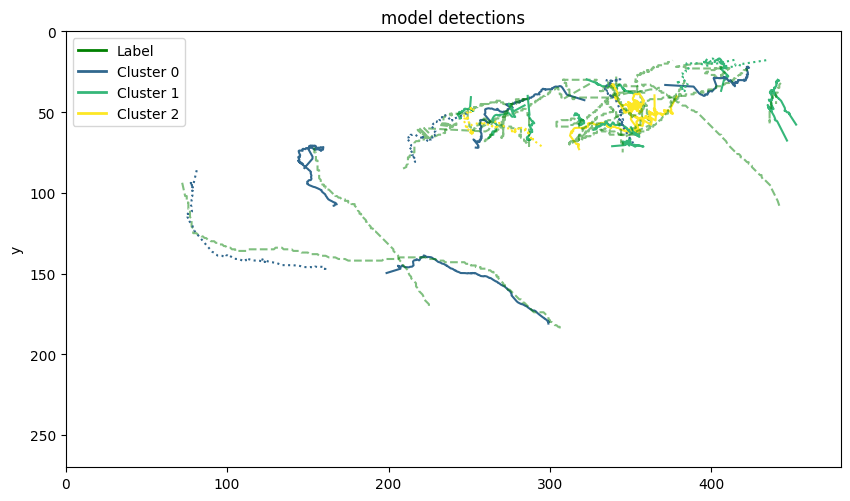

In [263]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

amount = 10000
alpha = 1
label_color = "green"

# Create a colormap with enough colors for each cluster
n_clusters = clustered_features['cluster'].nunique()
colormap = cm.get_cmap('viridis', n_clusters + 1)  # +1 for the ground truth color

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True,  figsize=(10, 10))
plt.gca().invert_yaxis()

# Plot model detections
for mmt_track_id, gt_track_id in mmt_gt_pairs:
    mmt_track_df = model_detections[model_detections.id == mmt_track_id]
    ax.plot(mmt_track_df.x, mmt_track_df.y, color=colormap(mmt_track_df.cluster.iloc[0] + 1))
    gt_track_df = ground_truth[ground_truth.id == gt_track_id]
    ax.plot(gt_track_df.x, gt_track_df.y, alpha=0.5, color=label_color, linestyle='dashed')
    
for mmt_track_id, gt_track_id in mmt_gt_pairs_secondary:
    mmt_track_df = model_detections[model_detections.id == mmt_track_id]
    ax.plot(mmt_track_df.x, mmt_track_df.y, color=colormap(mmt_track_df.cluster.iloc[0] + 1), linestyle='dotted')

ax.set(ylabel='y',
       title="model detections", ylim=[270, 0], xlim=[0, 480])
ax.set_aspect('equal', adjustable='box')

# Create a custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=label_color, lw=2, label='Label')]
for i in range(n_clusters):
    legend_elements.append(Line2D([0], [0], color=colormap(i + 1), lw=2, label=f'Cluster {i}'))
ax.legend(handles=legend_elements)

plt.show()


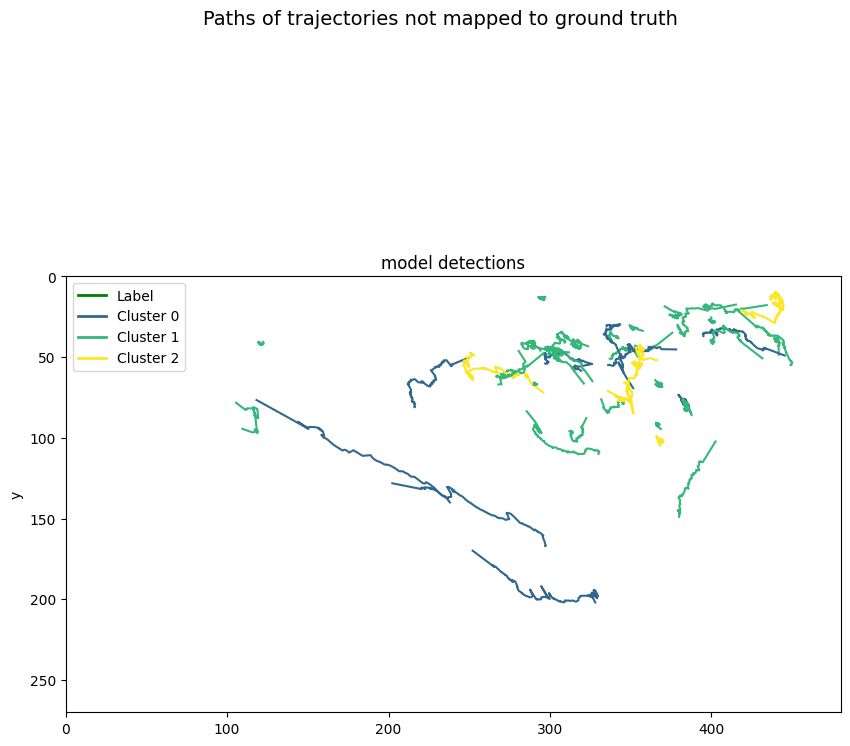

In [196]:
import matplotlib.pyplot as plt

# Create a colormap with enough colors for each cluster
n_clusters = clustered_features['cluster'].nunique()
colormap = cm.get_cmap('viridis', n_clusters + 1)  # +1 for the ground truth color

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 10))
plt.gca().invert_yaxis()

# Plot model detections
for track_row, track_id in enumerate(model_detections.id.unique()):
    if track_row not in row_indices:
        track_df = model_detections[model_detections.id == track_id]
        ax.plot(track_df.x, track_df.y, alpha=alpha, color=colormap(track_df.cluster.iloc[0] + 1))

ax.set(ylabel='y',
       title="model detections", ylim=[270, 0], xlim=[0, 480])
ax.set_aspect('equal', adjustable='box')
fig.suptitle(f"Paths of trajectories not mapped to ground truth", fontsize=14)

# Create a custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=label_color, lw=2, label='Label')]
for i in range(n_clusters):
    legend_elements.append(Line2D([0], [0], color=colormap(i + 1), lw=2, label=f'Cluster {i}'))
ax.legend(handles=legend_elements)

plt.show()


In [43]:
def plot_path(identifier, data, alpha, color):
    ylim=[270, 0] 
    xlim=[0, 480]
    plt.plot(data.loc[data.id == identifier, "x"], data.loc[data.id == identifier, "y"], alpha=alpha, color=color)
    plt.xlim(xlim)
    plt.ylim(ylim)

In [135]:
identifier_counts = model_detections.id.value_counts()

In [136]:
filtered_df = model_detections[model_detections['id'].isin(identifier_counts[identifier_counts >= 20].index)]

In [137]:
filtered_twice = filtered_df
#filtered_twice = filtered_df[filtered_df['id'].isin(identifier_counts[identifier_counts <= 360].index)]

In [138]:
def get_path(identifier, data):
    return data.loc[data.id == identifier, ["x", "y"]].to_numpy()

paths = []
paths_identifiers = []

for identifier in filtered_twice["id"].unique():
    path = get_path(identifier, filtered_df)
    paths.append(path)
    paths_identifiers.append(identifier)


In [139]:
paths_identifiers

[483,
 1619,
 1683,
 1970,
 2427,
 2688,
 2693,
 2760,
 2871,
 2875,
 2984,
 3062,
 3064,
 3229,
 3242,
 3514,
 3674,
 4042,
 4474,
 4760,
 5231,
 5640,
 5768,
 5799,
 5904,
 5936,
 6110,
 6326,
 6735,
 7011,
 7082,
 7312,
 7602,
 7950,
 8572,
 8807,
 8988,
 9362,
 9389,
 9420,
 9500,
 9612,
 9619,
 9689,
 9692,
 9712,
 9747,
 9765,
 10193,
 10281,
 10588,
 10695,
 10760,
 10780,
 11263,
 11579,
 12307,
 12394,
 12484,
 12931,
 12943]

In [140]:
def z_standardize(path):
    mean = np.mean(path, axis=0)
    std = np.std(path, axis=0)
    return (path - mean) / std

In [141]:
standardized_paths = [z_standardize(path) for path in paths]

In [142]:
from dtaidistance import dtw_ndim

from dtaidistance import dtw, clustering


In [143]:
hier = clustering.Hierarchical(dtw_ndim.distance_matrix, dists_options={"window": 40})

In [144]:
hier_tree = clustering.HierarchicalTree(hier)

In [145]:
fitting_result = hier_tree.fit(standardized_paths)

In [73]:
fitting_result

{0: {0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34}}

In [146]:
hier_tree.linkage

[(42, 10, 0.3150674637738828, 0),
 (46, 11, 0.6224777187106855, 0),
 (62, 61, 0.8495667964397283, 0),
 (41, 32, 0.9018444363115276, 0),
 (64, 16, 1.1169773008345472, 0),
 (38, 63, 1.1286198477186027, 0),
 (37, 66, 1.6856513538155147, 0),
 (26, 67, 1.699918519638672, 0),
 (40, 27, 2.1913276109075808, 0),
 (31, 65, 2.730511469176569, 0),
 (45, 70, 2.816317687753955, 0),
 (69, 14, 3.0476147930312525, 0),
 (71, 15, 3.1299814858799375, 0),
 (56, 47, 3.4736388852440214, 0),
 (54, 36, 3.5094698909225843, 0),
 (74, 75, 4.6384418405936385, 0),
 (18, 68, 4.702891169570101, 0),
 (21, 73, 4.855332233773589, 0),
 (52, 23, 4.864974625935046, 0),
 (51, 12, 5.4944080994282745, 0),
 (39, 77, 5.69408741226771, 0),
 (22, 17, 5.8927746426858665, 0),
 (19, 4, 6.27770638156315, 0),
 (82, 72, 6.394890646631817, 0),
 (44, 78, 6.4139289040402865, 0),
 (53, 49, 6.627627740356647, 0),
 (30, 29, 6.756760771970712, 0),
 (59, 5, 7.720056640702918, 0),
 (60, 85, 7.834417408765528, 0),
 (88, 0, 7.907171780337212, 0),

In [147]:
from scipy.cluster.hierarchy import dendrogram

In [148]:
len(paths)

61

In [149]:
hier_tree.linkage

[(42, 10, 0.3150674637738828, 0),
 (46, 11, 0.6224777187106855, 0),
 (62, 61, 0.8495667964397283, 0),
 (41, 32, 0.9018444363115276, 0),
 (64, 16, 1.1169773008345472, 0),
 (38, 63, 1.1286198477186027, 0),
 (37, 66, 1.6856513538155147, 0),
 (26, 67, 1.699918519638672, 0),
 (40, 27, 2.1913276109075808, 0),
 (31, 65, 2.730511469176569, 0),
 (45, 70, 2.816317687753955, 0),
 (69, 14, 3.0476147930312525, 0),
 (71, 15, 3.1299814858799375, 0),
 (56, 47, 3.4736388852440214, 0),
 (54, 36, 3.5094698909225843, 0),
 (74, 75, 4.6384418405936385, 0),
 (18, 68, 4.702891169570101, 0),
 (21, 73, 4.855332233773589, 0),
 (52, 23, 4.864974625935046, 0),
 (51, 12, 5.4944080994282745, 0),
 (39, 77, 5.69408741226771, 0),
 (22, 17, 5.8927746426858665, 0),
 (19, 4, 6.27770638156315, 0),
 (82, 72, 6.394890646631817, 0),
 (44, 78, 6.4139289040402865, 0),
 (53, 49, 6.627627740356647, 0),
 (30, 29, 6.756760771970712, 0),
 (59, 5, 7.720056640702918, 0),
 (60, 85, 7.834417408765528, 0),
 (88, 0, 7.907171780337212, 0),

In [2]:
plt.figure(figsize=(25, 10))

dendrogram(hier_tree.linkage, labels=filtered_twice["id"].unique(), truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True, )
plt.savefig('wat.png')


NameError: name 'plt' is not defined

In [79]:
wat = clustering.KMeans(k=2).fit(standardized_paths)

{}
14.874085979527512


In [80]:
wat

({0: {0,
   2,
   3,
   4,
   6,
   7,
   8,
   10,
   12,
   13,
   15,
   16,
   17,
   20,
   21,
   23,
   24,
   26,
   27,
   28,
   29,
   31,
   32,
   33},
  1: {1, 5, 9, 11, 14, 18, 19, 22, 25, 30, 34}},
 3)

In [151]:
medoids = clustering.KMedoids(dtw_ndim.distance_matrix, dists_options={"window": 40}, k=2)

In [152]:
med_result = medoids.fit(standardized_paths)

In [153]:
med_result

{10: {2,
  3,
  5,
  7,
  10,
  11,
  13,
  14,
  17,
  18,
  23,
  24,
  25,
  26,
  27,
  29,
  30,
  33,
  37,
  38,
  39,
  42,
  46,
  47,
  52,
  56,
  57,
  59},
 32: {0,
  1,
  4,
  6,
  8,
  9,
  12,
  15,
  16,
  19,
  20,
  21,
  22,
  28,
  31,
  32,
  34,
  35,
  36,
  40,
  41,
  43,
  44,
  45,
  48,
  49,
  50,
  51,
  53,
  54,
  55,
  58,
  60}}

In [154]:
med_result.keys()

dict_keys([10, 32])

In [155]:
new_fish = []
clusters = wat[0]
for i, identifier in enumerate(paths_identifiers):
    if i in clusters.get(1, []):
        new_fish.append(identifier)

In [224]:
def plot_path_numpy(data, alpha, color, text=""):
    ylim=[270, 0] 
    xlim=[0, 480]
    plt.plot(data[:,0], data[:,1], alpha=alpha, color=color)
    plt.text(x = data[0,0],y = data[0,1],s=text)
    plt.xlim(xlim)
    plt.ylim(ylim)

In [171]:
%matplotlib widget


In [225]:
plt.close()

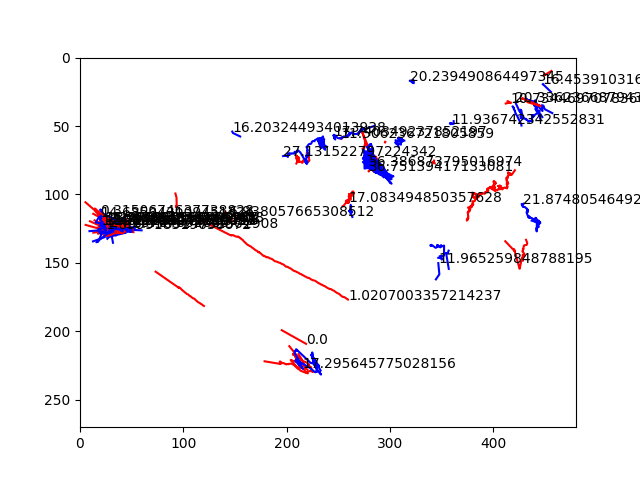

In [226]:
clusters = med_result
#clusters = wat[0]
for i in range(0, len(paths)):
    if i in clusters.get(10):
        color = "red"
    if i in clusters.get(32):
        color = "blue"
    #if i in clusters.get(0, []):
    #    color = "red"
    #if i in clusters.get(1, []):
    #    color = "blue"
    #if i in clusters.get(2, []):
    #    color = "green"
    #if i in clusters.get(3, []):
    #    color = "yellow"
    distance = dtw_ndim.distance(standardized_paths[i], standardized_paths[10], window=40)  if i % 2== 0 else ""
   # distance = ""

    plot_path_numpy(paths[i], 1, color, distance)

In [174]:
plot_path_numpy(paths[10], 1, "yellow")

In [ ]:
plot_path_numpy(paths[53], 1, "red")

In [ ]:
plot_path_numpy(paths[14], 0.2, "blue")

In [ ]:
standardized_paths[14]

In [ ]:
plt.plot(standardized_paths[14][:,0], standardized_paths[14][:,1], alpha=1, color=fish_color)


In [ ]:
plt.plot(standardized_paths[15][:,0], standardized_paths[15][:,1], alpha=1, color=fish_color)


In [ ]:
plt.plot(ground_truth["x"], ground_truth["y"], alpha=alpha, color=fish_color)


In [ ]:
len(paths)

In [ ]:
get_path(13410, model_detections)

In [ ]:
path = model_detections[model_detections['id']==13410][["x", "y"]].to_numpy()

In [ ]:
another_path = model_detections[model_detections['id']==14868][["x", "y"]].to_numpy()


In [ ]:
another_path.shape

In [ ]:
dtw_ndim.distance(path, another_path)

In [ ]:
dtw_ndim.distance(path, path)


In [ ]:
path.shape

In [ ]:
import numpy as np

In [ ]:
series1 = np.array([[0, 0],  # first point at t=0
                    [0, 1],  # second point at t=1
                    [2, 1],
                    [0, 1],
                    [0, 0]], dtype=np.double)


## Tested until here with new code

In [ ]:
few_fish_night_csv = "v2_output_02-23.csv"
many_fish_afternoon_csv = "v2_output_16-46.csv"
few_fish = pd.read_csv(few_fish_night_csv, delimiter=",")
many_fish = pd.read_csv(many_fish_afternoon_csv, delimiter=",")

value_counts_few = pd.DataFrame(few_fish.ID.value_counts()).reset_index().rename(columns={"index": "ID", "ID": "occurences"})
value_counts_many = pd.DataFrame(many_fish.ID.value_counts()).reset_index().rename(columns={"index": "ID", "ID": "occurences"})

In [ ]:
# value_counts_few.plot.bar(x='ID', y='occurences')
value_counts_few.head(200)

In [ ]:
amount = 100
alpha = 0.3
fish_color = "red"
object_color = "grey"

fig, [ax, ax1] = plt.subplots(nrows=2, ncols=1, sharex=True,  figsize=(10, 10))
plt.gca().invert_yaxis()

data = few_fish
for object in value_counts_few.ID.tolist()[:amount]:
    color = object_color
    ax.plot(data.loc[data.ID == object, "x"], data.loc[data.ID == object, "y"], alpha=alpha, color=color)

data = many_fish
for object in value_counts_many.ID.tolist()[:amount]:
    color = object_color
    ax1.plot(data.loc[data.ID == object, "x"], data.loc[data.ID == object, "y"], alpha=alpha, color=color)


ax.set(ylabel='y',
       title="no fish \n" + few_fish_night_csv, ylim=[270, 0], xlim=[0, 480])
ax1.set(xlabel='x', title="many fish \n" + many_fish_afternoon_csv, ylim=[270, 0], xlim=[0, 480])
ax.set_aspect('equal', adjustable='box')
ax1.set_aspect('equal', adjustable='box')
fig.suptitle(f"Paths of {amount} longest lasting objects", fontsize=14)

line1 = ax.plot([],[], color=fish_color, label='Fish')
line2 = ax.plot([],[], color=object_color, label='Object')
ax.legend()
line1 = ax1.plot([],[], color=fish_color, label='Fish')
line2 = ax1.plot([],[], color=object_color, label='Object')
ax1.legend()

plt.show()

In [ ]:
many_fish_min_50 = many_fish.loc[many_fish.ID.isin(value_counts_many.loc[value_counts_many["occurences"]>50, "ID"])]

In [ ]:
many_fish_min_50.groupby("ID").apply(lambda x: np.polyfit(x.x, x.y, deg=1)[0]).reset_index().sort_values(0).plot.hist(x="ID", y=0, bins=50)

In [ ]:
few_fish_min_50 = few_fish.loc[few_fish.ID.isin(value_counts_few.loc[value_counts_few["occurences"]>50, "ID"])]

In [ ]:
few_fish_min_50.groupby("ID").apply(lambda x: np.polyfit(x.x, x.y, deg=1)[0]).reset_index().sort_values(0).plot.hist(x="ID", y=0, bins=30)